In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from math import sqrt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

## Functions

In [3]:
def smape(y_actual, y_pred):
    denominator = np.abs(y_actual) + np.abs(y_pred)
    diff = np.abs(y_actual - y_pred) / denominator
    diff[denominator == 0] = 0  # If both y_actual and y_pred are zero, set to zero
    return np.mean(diff) * 100

## EDA

In [4]:
df = pd.read_csv('merged_table.csv')
print(df.head())

    date      time  ni_in  fe_in  sio2_in  cao_in  mgo_in  al2o3_in  fe_ni  \
0  44197  0.000000   2.09  12.68    37.85    0.42   20.13      1.25   6.06   
1  44197  0.041667   2.09  12.68    37.85    0.42   20.13      1.25   6.06   
2  44197  0.083333   2.09  12.68    37.85    0.42   20.13      1.25   6.06   
3  44197  0.125000   2.09  12.68    37.85    0.42   20.13      1.25   6.06   
4  44197  0.166667   2.09  12.68    37.85    0.42   20.13      1.25   6.06   

    s_m  ...  ni_met  c_met  si_met   fe_met   s_met  ni_slag  fe_slag  \
0  1.88  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
1  1.88  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
2  1.88  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
3  1.88  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
4  1.88  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   

   t_kalsin  pic_161  loi_kalsin  
0     627.0     -3.0        0.71  
1     607.0     

### Drop and shift some rows

In [5]:
datetime_cols = df.loc[:, 'date':'time'].columns
input_cols = df.loc[:, 'ni_in':'t_tic172'].columns
output_cols = df.loc[:, 'furnace_temp':'loi_kalsin'].columns

# drop rows with on 4/1/2021 to 6/1/2021 and 21/1/2021 to 22/1/2021
df = df[~df['date'].between(44200, 44202)]
df = df[~df['date'].between(44217, 44218)]

shifted_output_df = df[output_cols].shift(16)
df = pd.concat([df[datetime_cols], df[input_cols], shifted_output_df], axis=1)
df = df.drop(index=range(16))

#shift column tco, coltage, current, load, reductor_ratio, charge_kiln 7 rows up
columns_to_shift = ['tco', 'voltage', 'current', 'load', 'reductor_ratio', 'charge_kiln']

# Shift kolom tertentu ke atas 7 baris
shifted_columns = df[columns_to_shift].shift(-7)

# Mengganti kolom asli dengan versi yang telah di-shift
df[columns_to_shift] = shifted_columns

# Menghapus baris terakhir sebanyak 7 baris karena menjadi NaN setelah shift
df = df.iloc[:-7]

df = df.reset_index(drop=True)
print(df.head())

    date      time  ni_in  fe_in  sio2_in  cao_in  mgo_in  al2o3_in  fe_ni  \
0  44197  0.666667   2.05  12.77    37.58    0.45   20.30      1.37   6.23   
1  44197  0.708333   2.00  10.97    36.39    0.36   19.54      1.13   5.50   
2  44197  0.750000   2.00  10.97    36.39    0.36   19.54      1.13   5.50   
3  44197  0.791667   2.00  10.97    36.39    0.36   19.54      1.13   5.50   
4  44197  0.833333   2.00  10.97    36.39    0.36   19.54      1.13   5.50   

    s_m  ...  ni_met  c_met  si_met   fe_met   s_met  ni_slag  fe_slag  \
0  1.86  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
1  1.86  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
2  1.86  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
3  1.86  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   
4  1.86  ...    20.8  1.294   1.284  74.8144  0.5044     0.07     7.22   

   t_kalsin  pic_161  loi_kalsin  
0     627.0     -3.0        0.71  
1     607.0     

In [6]:
df.to_csv('shifted_data.csv', index=False)

In [6]:
df.isnull().sum()

date                 0
time                 0
ni_in                9
fe_in                9
sio2_in              9
cao_in               9
mgo_in               9
al2o3_in             9
fe_ni                9
s_m                  9
bc                   9
loi_in              33
mc_kilnfeed          8
fc_coal             16
gcv_coal            16
tco                  0
voltage              0
current              0
load                 0
rpm                 88
pry_p               88
sec_p               88
pry_v               88
sec_v               88
total_coal          88
a_f_ratio           88
kg_tco              88
reductor_ratio       0
reductor_consume     0
charge_kiln          0
t_tic162            88
t_tic163            88
t_tic166            88
t_tic172            88
furnace_temp         0
ni_met               0
c_met                0
si_met               0
fe_met               0
s_met                0
ni_slag              0
fe_slag              0
t_kalsin            88
pic_161    

In [7]:
df = df.astype('float64', errors='ignore')
df.dtypes

date                float64
time                float64
ni_in               float64
fe_in               float64
sio2_in             float64
cao_in              float64
mgo_in              float64
al2o3_in            float64
fe_ni               float64
s_m                 float64
bc                  float64
loi_in              float64
mc_kilnfeed         float64
fc_coal             float64
gcv_coal            float64
tco                 float64
voltage             float64
current             float64
load                float64
rpm                 float64
pry_p               float64
sec_p               float64
pry_v               float64
sec_v               float64
total_coal          float64
a_f_ratio           float64
kg_tco              float64
reductor_ratio      float64
reductor_consume    float64
charge_kiln         float64
t_tic162            float64
t_tic163            float64
t_tic166            float64
t_tic172            float64
furnace_temp        float64
ni_met              

In [8]:
df = df.drop(columns=['date', 'time'])
df.columns
df.head()

,ni_in,fe_in,sio2_in,cao_in,mgo_in,al2o3_in,fe_ni,s_m,bc,loi_in,...,ni_met,c_met,si_met,fe_met,s_met,ni_slag,fe_slag,t_kalsin,pic_161,loi_kalsin
0,2.05,12.77,37.58,0.45,20.30,1.37,6.23,1.86,0.55,11.17,...,20.8,1.294,1.284,74.8144,0.5044,0.07,7.22,627.0,-3.0,0.71
1,2.00,10.97,36.39,0.36,19.54,1.13,5.50,1.86,0.54,12.98,...,20.8,1.294,1.284,74.8144,0.5044,0.07,7.22,607.0,-2.7,0.71
2,2.00,10.97,36.39,0.36,19.54,1.13,5.50,1.86,0.54,12.98,...,20.8,1.294,1.284,74.8144,0.5044,0.07,7.22,614.0,-3.1,0.71
3,2.00,10.97,36.39,0.36,19.54,1.13,5.50,1.86,0.54,12.98,...,20.8,1.294,1.284,74.8144,0.5044,0.07,7.22,620.0,-0.9,0.90
4,2.00,10.97,36.39,0.36,19.54,1.13,5.50,1.86,0.54,12.98,...,20.8,1.294,1.284,74.8144,0.5044,0.07,7.22,610.0,-3.0,0.90


### Interpolation

In [9]:
df[input_cols.union(output_cols)] = df[input_cols.union(output_cols)].interpolate(method='linear', axis=0)
print(df[input_cols.union(output_cols)].isnull().sum())

a_f_ratio           0
al2o3_in            0
bc                  0
c_met               0
cao_in              0
charge_kiln         0
current             0
fc_coal             0
fe_in               0
fe_met              0
fe_ni               0
fe_slag             0
furnace_temp        0
gcv_coal            0
kg_tco              0
load                0
loi_in              0
loi_kalsin          0
mc_kilnfeed         0
mgo_in              0
ni_in               0
ni_met              0
ni_slag             0
pic_161             0
pry_p               0
pry_v               0
reductor_consume    0
reductor_ratio      0
rpm                 0
s_m                 0
s_met               0
sec_p               0
sec_v               0
si_met              0
sio2_in             0
t_kalsin            0
t_tic162            0
t_tic163            0
t_tic166            0
t_tic172            0
tco                 0
total_coal          0
voltage             0
dtype: int64


In [10]:
df.isnull().sum()

ni_in               0
fe_in               0
sio2_in             0
cao_in              0
mgo_in              0
al2o3_in            0
fe_ni               0
s_m                 0
bc                  0
loi_in              0
mc_kilnfeed         0
fc_coal             0
gcv_coal            0
tco                 0
voltage             0
current             0
load                0
rpm                 0
pry_p               0
sec_p               0
pry_v               0
sec_v               0
total_coal          0
a_f_ratio           0
kg_tco              0
reductor_ratio      0
reductor_consume    0
charge_kiln         0
t_tic162            0
t_tic163            0
t_tic166            0
t_tic172            0
furnace_temp        0
ni_met              0
c_met               0
si_met              0
fe_met              0
s_met               0
ni_slag             0
fe_slag             0
t_kalsin            0
pic_161             0
loi_kalsin          0
dtype: int64

In [11]:
df.to_csv('interpolated_data.csv', index=False)

In [37]:
## Rotary Kiln Columns

rk_cols = ['ni_in', 'fe_in', 'sio2_in', 'cao_in', 'mgo_in', 'al2o3_in', 'fe_ni',
            's_m', 'bc', 'loi_in', 'mc_kilnfeed', 'fc_coal', 'gcv_coal', 'tco', 
            'rpm', 'pry_p', 'sec_p', 'pry_v', 'sec_v', 'total_coal', 'a_f_ratio', 
            'kg_tco', 'reductor_ratio', 'reductor_consume', 'charge_kiln', 
            't_tic162', 't_tic163', 't_tic166', 't_tic172', 't_kalsin', 'pic_161', 'loi_kalsin']

rk_input_cols = ['ni_in', 'fe_in', 'sio2_in', 'cao_in', 'mgo_in', 'al2o3_in', 'fe_ni',
                's_m', 'bc', 'loi_in', 'mc_kilnfeed', 'fc_coal', 'gcv_coal', 'tco', 
                'rpm', 'pry_p', 'sec_p', 'pry_v', 'sec_v', 'total_coal', 'a_f_ratio', 
                'kg_tco', 'reductor_ratio', 'reductor_consume', 'charge_kiln']

rk_output_cols = ['t_tic162', 't_tic163', 't_tic166', 't_tic172', 't_kalsin', 'pic_161', 'loi_kalsin']

## Electric Furnace Columns

ef_cols = ['ni_in', 'fe_in', 'sio2_in', 'cao_in', 'mgo_in', 'al2o3_in', 'fe_ni',
           's_m', 'bc', 'fc_coal', 'gcv_coal', 'voltage', 'current', 'load',
           'total_coal', 'reductor_ratio', 'reductor_consume', 'charge_kiln', 't_kalsin', 'pic_161', 'loi_kalsin',
           't_tic162', 't_tic163', 't_tic166', 't_tic172', 'furnace_temp', 'ni_met', 'c_met', 'si_met', 'fe_met', 's_met', 'ni_slag', 'fe_slag']


ef_input_cols = ['ni_in', 'fe_in', 'sio2_in', 'cao_in', 'mgo_in', 'al2o3_in', 'fe_ni',
                's_m', 'bc', 'fc_coal', 'gcv_coal', 'voltage', 'current', 'load',
                'total_coal', 'reductor_ratio', 'reductor_consume', 'charge_kiln', 't_kalsin', 'pic_161', 'loi_kalsin']

ef_output_cols = ['t_tic162', 't_tic163', 't_tic166', 't_tic172', 'furnace_temp', 'ni_met', 'c_met', 'si_met', 'fe_met', 's_met', 'ni_slag', 'fe_slag']

### Outlier Removal

In [13]:
# # Calculate the IQR for each column and remove outliers
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1

# # Filter out rows where any column has a value outside the IQR range
# df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
# df = df.reset_index(drop=True)

# print(f"Cleaned shape (IQR method): {df.shape}")


### Normalization

In [44]:
scaler = MinMaxScaler()

normalizeds_data = scaler.fit_transform(df)
normalizeds_df = pd.DataFrame(normalizeds_data, columns=df.columns)

normalizeds_df.head()

,ni_in,fe_in,sio2_in,cao_in,mgo_in,al2o3_in,fe_ni,s_m,bc,loi_in,...,ni_met,c_met,si_met,fe_met,s_met,ni_slag,fe_slag,t_kalsin,pic_161,loi_kalsin
0,0.705263,0.362903,0.360955,0.310680,0.269965,0.436306,0.26961,0.462966,0.441767,0.232796,...,0.631934,0.582781,0.397068,0.424716,0.397656,0.909091,0.43017,0.515267,0.356164,0.682692
1,0.600000,0.000000,0.193820,0.135922,0.162544,0.359873,0.00000,0.462966,0.388446,0.497804,...,0.631934,0.582781,0.397068,0.424716,0.397656,0.909091,0.43017,0.438931,0.397260,0.682692
2,0.600000,0.000000,0.193820,0.135922,0.162544,0.359873,0.00000,0.462966,0.388446,0.497804,...,0.631934,0.582781,0.397068,0.424716,0.397656,0.909091,0.43017,0.465649,0.342466,0.682692
3,0.600000,0.000000,0.193820,0.135922,0.162544,0.359873,0.00000,0.462966,0.388446,0.497804,...,0.631934,0.582781,0.397068,0.424716,0.397656,0.909091,0.43017,0.488550,0.643836,0.865385
4,0.600000,0.000000,0.193820,0.135922,0.162544,0.359873,0.00000,0.462966,0.388446,0.497804,...,0.631934,0.582781,0.397068,0.424716,0.397656,0.909091,0.43017,0.450382,0.356164,0.865385


In [39]:
rk_df = df[rk_cols]
ef_df = df[ef_cols]

# Further separate into input and output for each
rk_input_df = rk_df[rk_input_cols]
rk_output_df = rk_df[rk_output_cols]

ef_input_df = ef_df[ef_input_cols]
ef_output_df = ef_df[ef_output_cols]

In [53]:
# Separate scalers for inputs and outputs
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

# RK DATA
normalized_input_rk = input_scaler.fit_transform(df[rk_input_cols])
normalized_output_rk = output_scaler.fit_transform(df[rk_output_cols])

# Create normalized dataframes
normalized_input_rk_df = pd.DataFrame(normalized_input_rk, columns=rk_input_cols)
normalized_output_rk_df = pd.DataFrame(normalized_output_rk, columns=rk_output_cols)

# Combine into a single dataframe if needed
normalized_rk_df = pd.concat([normalized_input_rk_df, normalized_output_rk_df], axis=1)

# EF DATA
normalized_input_ef = input_scaler.fit_transform(df[ef_input_cols])
normalized_output_ef = output_scaler.fit_transform(df[ef_output_cols])

# Create normalized dataframes
normalized_input_ef_df = pd.DataFrame(normalized_input_ef, columns=ef_input_cols)
normalized_output_ef_df = pd.DataFrame(normalized_output_ef, columns=ef_output_cols)

# Combine into a single dataframe if needed
normalized_ef_df = pd.concat([normalized_input_ef_df, normalized_output_ef_df], axis=1)


In [82]:
normalized_rk_df.isna().sum()

ni_in               0
fe_in               0
sio2_in             0
cao_in              0
mgo_in              0
al2o3_in            0
fe_ni               0
s_m                 0
bc                  0
loi_in              0
mc_kilnfeed         0
fc_coal             0
gcv_coal            0
tco                 0
rpm                 0
pry_p               0
sec_p               0
pry_v               0
sec_v               0
total_coal          0
a_f_ratio           0
kg_tco              0
reductor_ratio      0
reductor_consume    0
charge_kiln         0
t_tic162            0
t_tic163            0
t_tic166            0
t_tic172            0
t_kalsin            0
pic_161             0
loi_kalsin          0
dtype: int64

In [55]:
normalized_ef_df.isna().sum()

ni_in               0
fe_in               0
sio2_in             0
cao_in              0
mgo_in              0
al2o3_in            0
fe_ni               0
s_m                 0
bc                  0
fc_coal             0
gcv_coal            0
voltage             0
current             0
load                0
total_coal          0
reductor_ratio      0
reductor_consume    0
charge_kiln         0
t_kalsin            0
pic_161             0
loi_kalsin          0
t_tic162            0
t_tic163            0
t_tic166            0
t_tic172            0
furnace_temp        0
ni_met              0
c_met               0
si_met              0
fe_met              0
s_met               0
ni_slag             0
fe_slag             0
dtype: int64

### Correlation Matrix

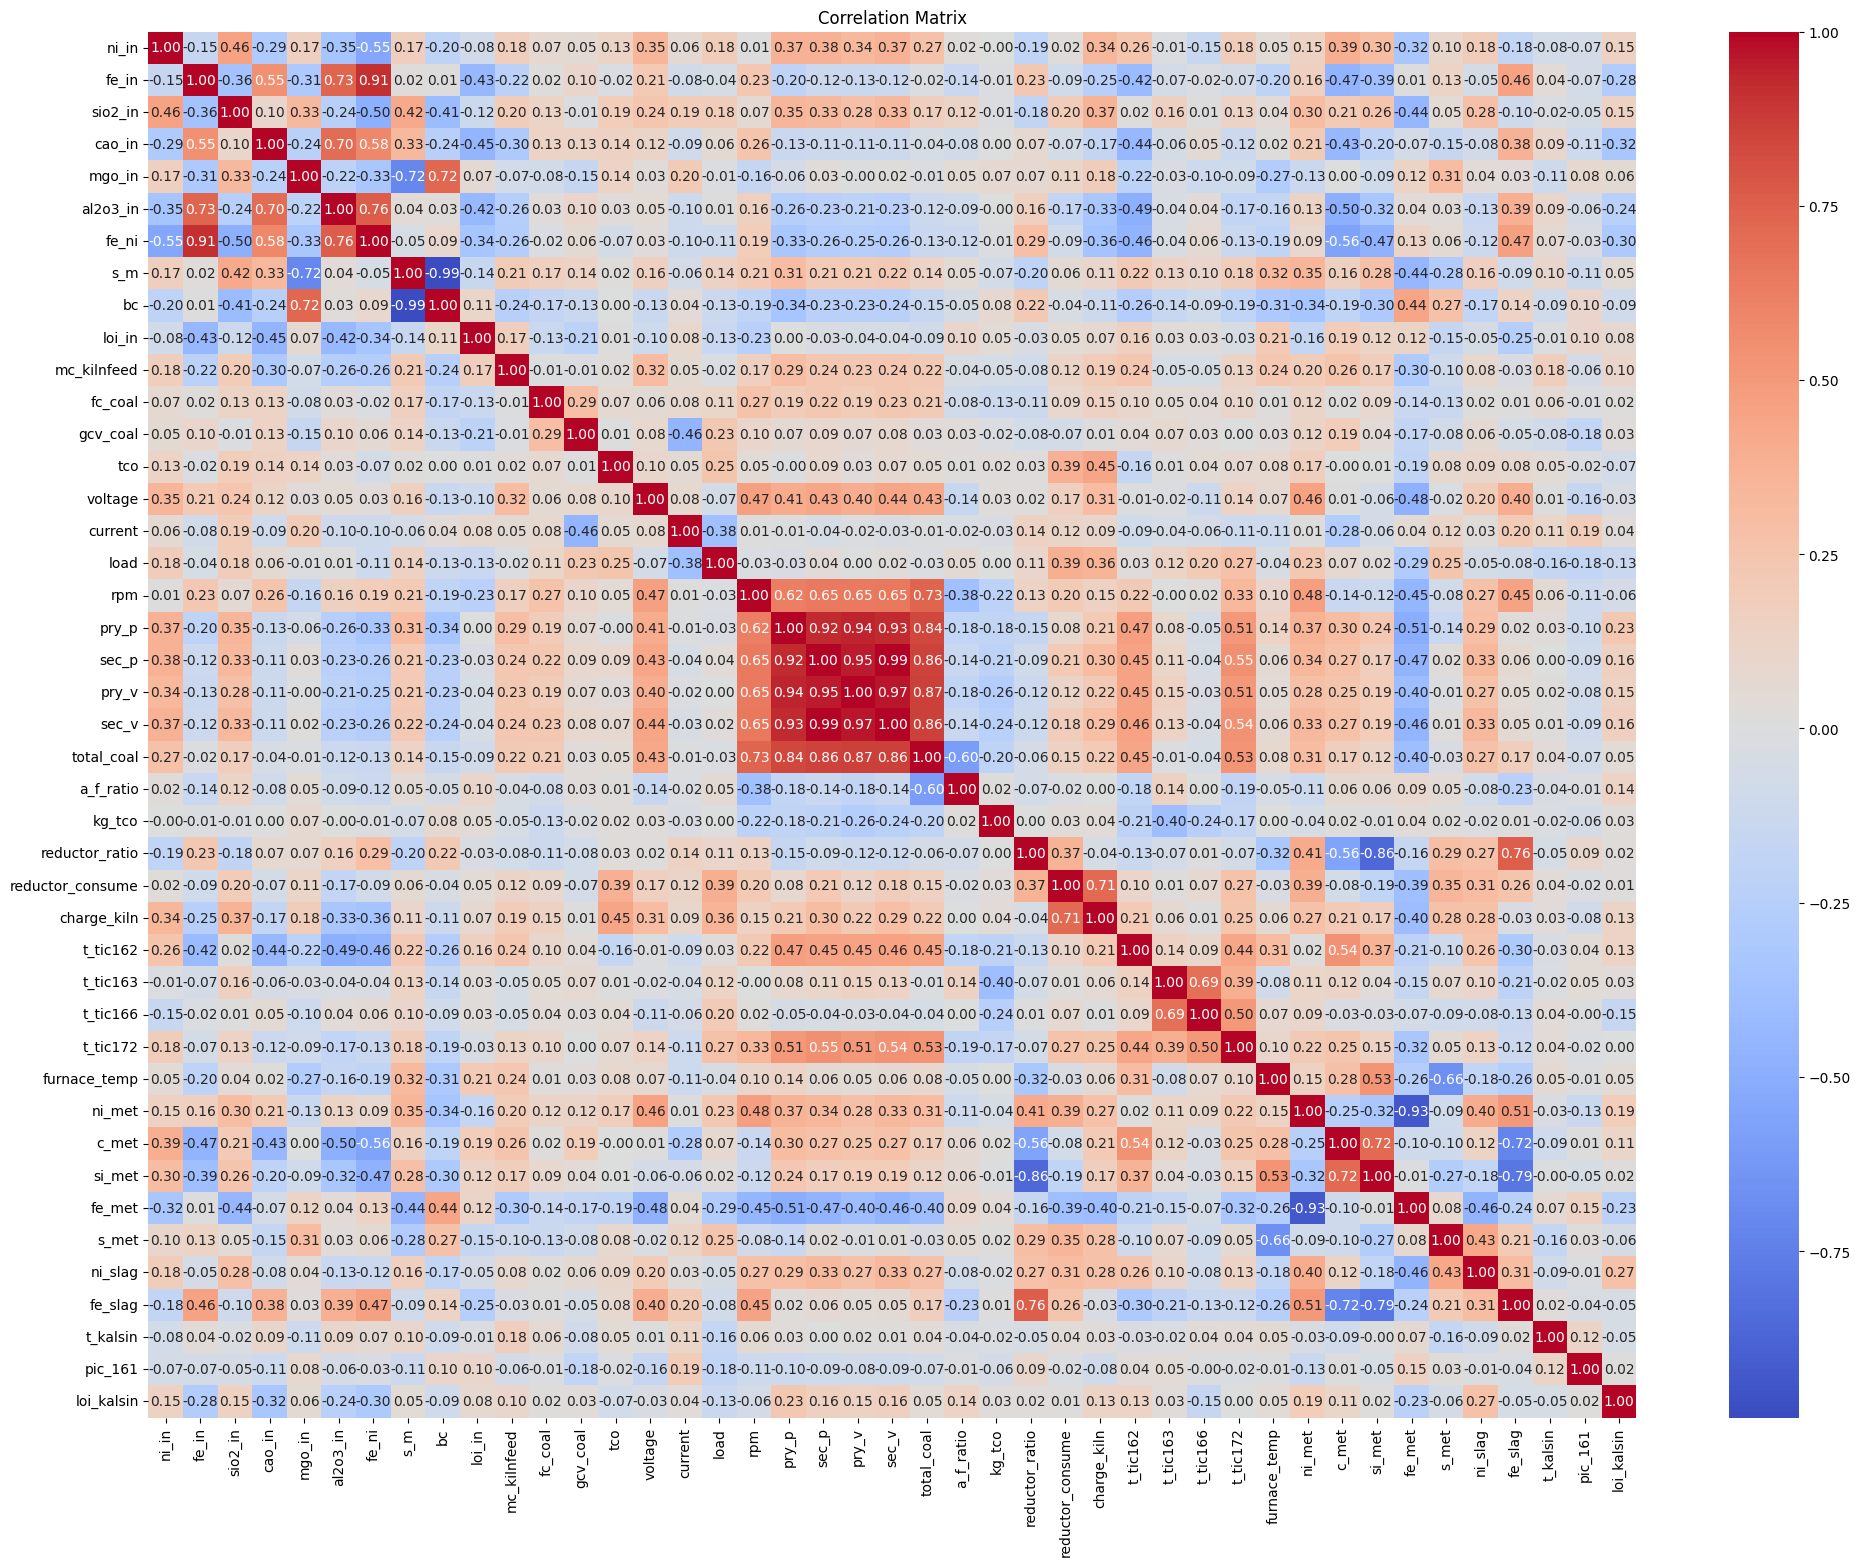

In [45]:
df_corr = normalizeds_df.corr()
plt.figure(figsize=(24, 18))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix_16.png', dpi=300)
plt.show()

### Scatter plots

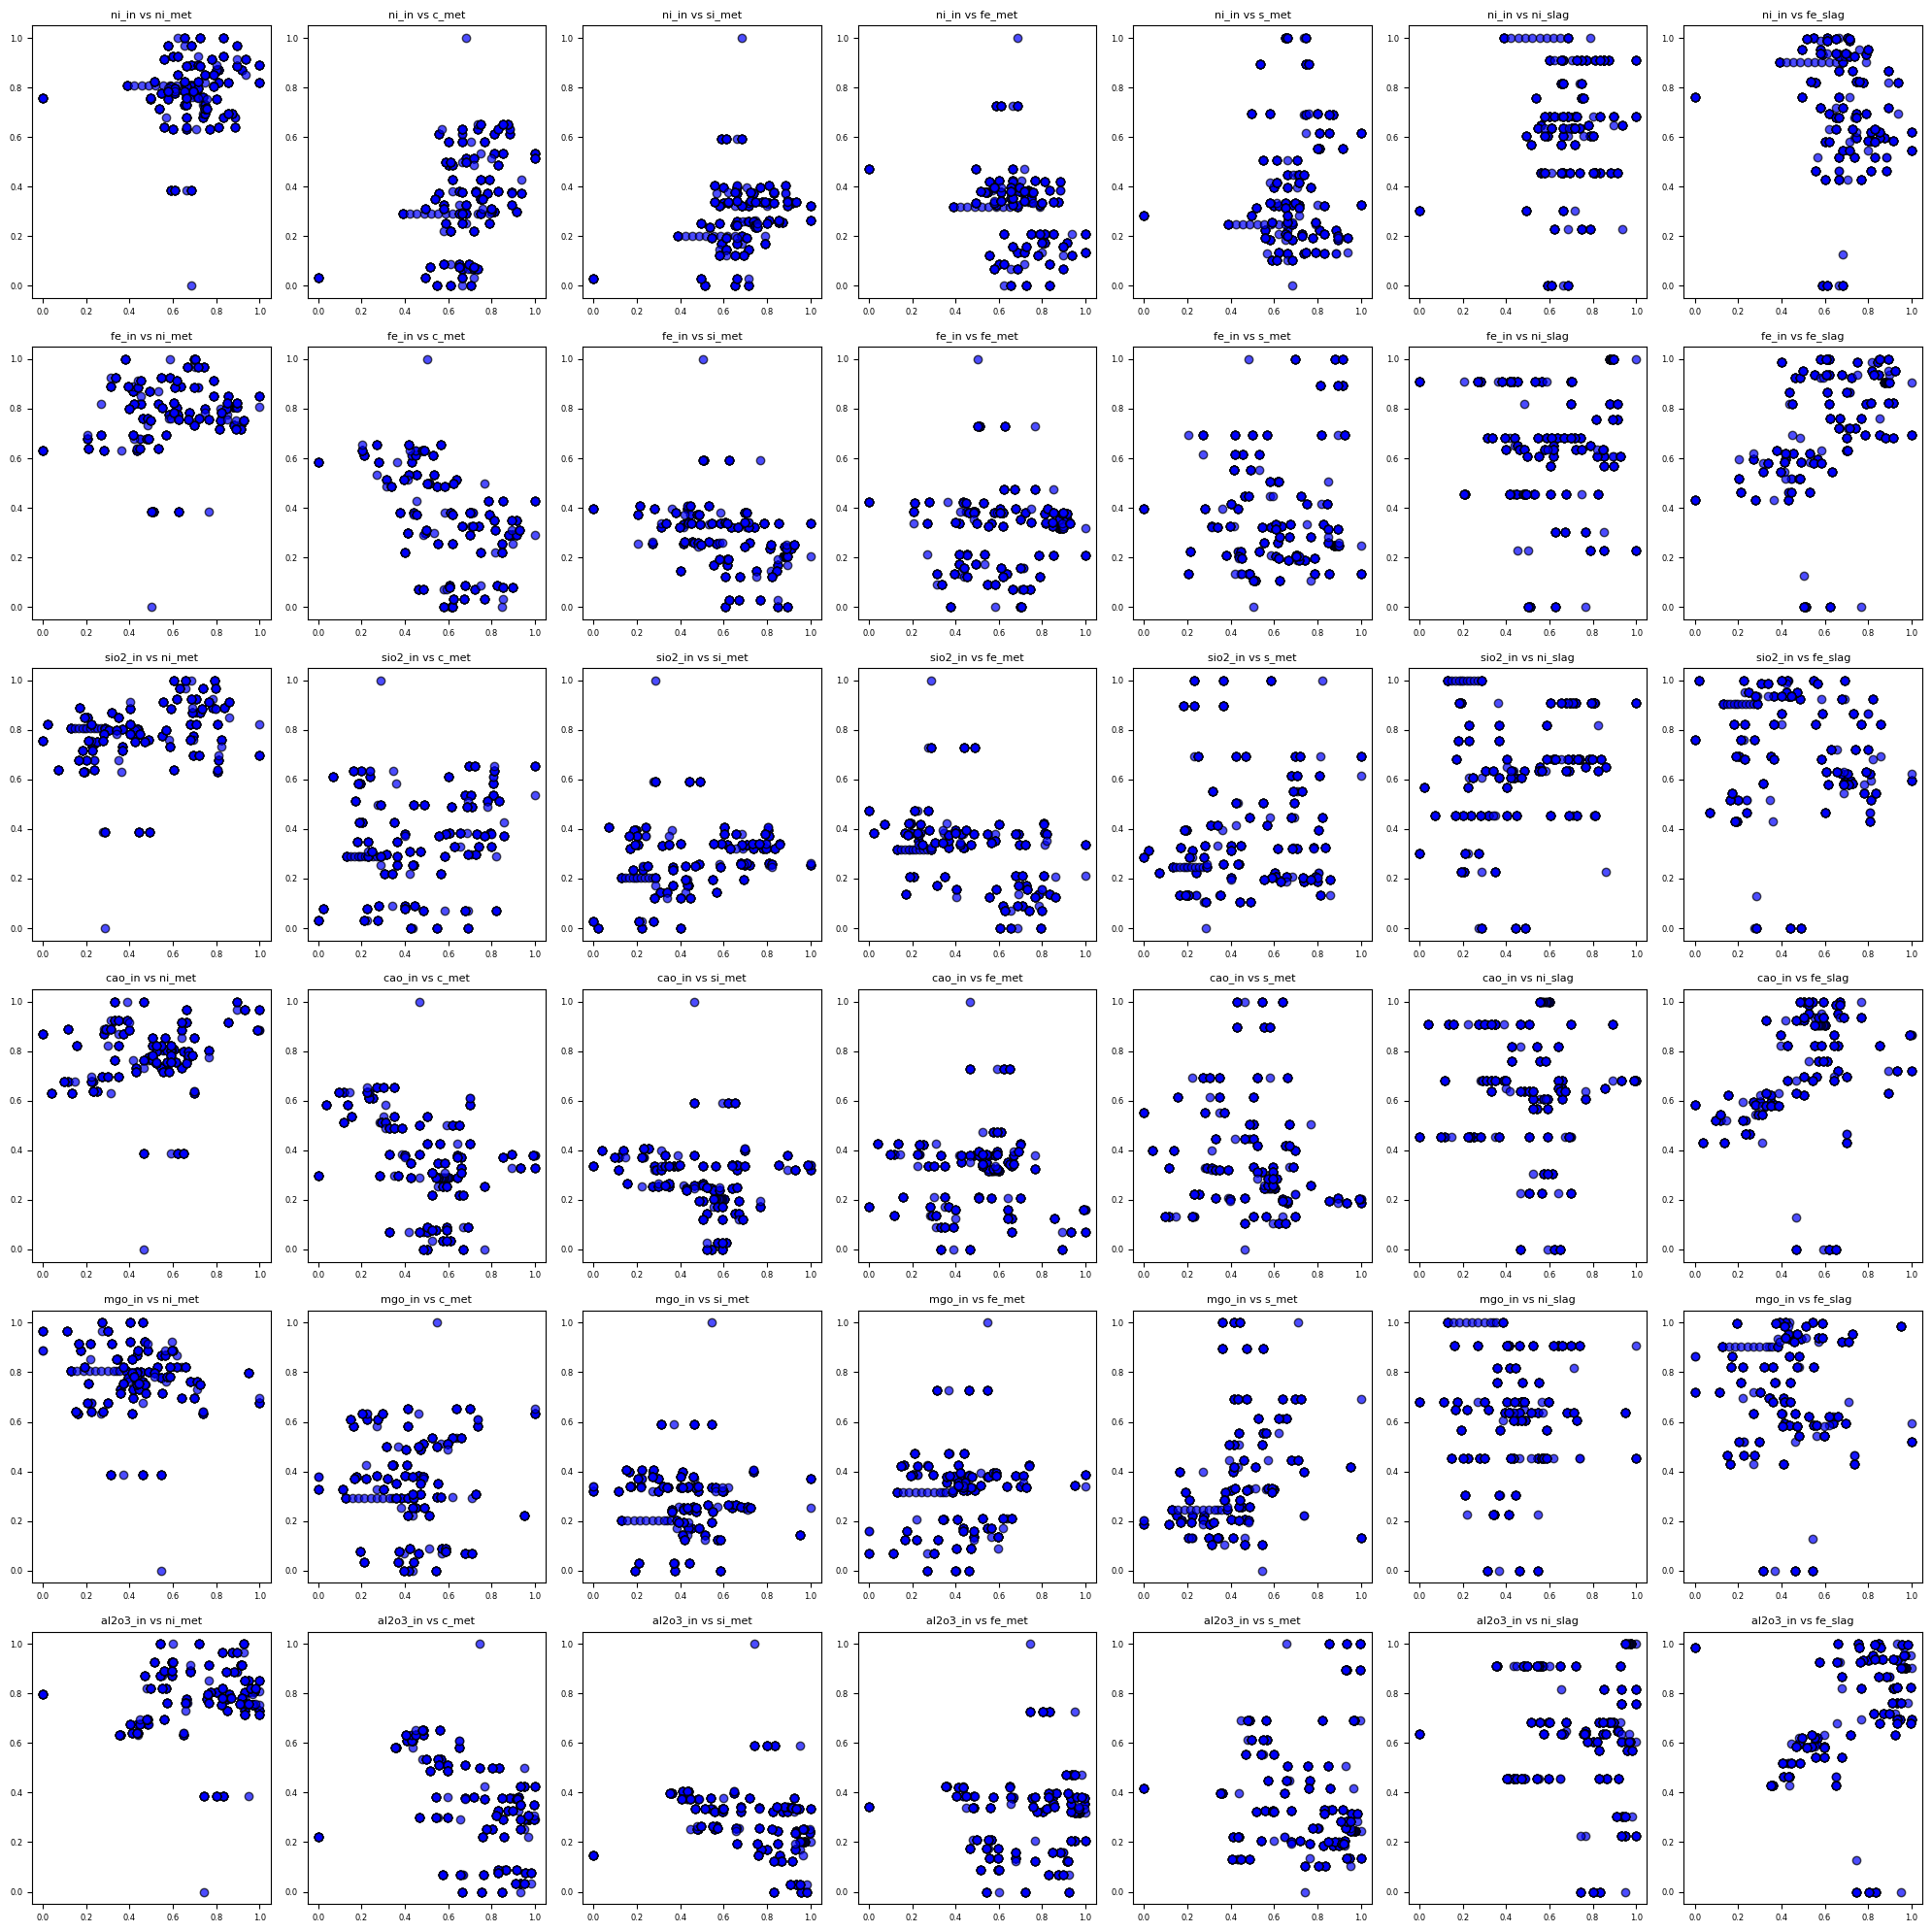

In [47]:
x_columns = normalizeds_df.loc[:, 'ni_in':'al2o3_in'].columns
y_columns = normalizeds_df.loc[:, 'ni_met':'fe_slag'].columns

# Setup grid untuk subplots
n_rows = len(x_columns)
n_cols = len(y_columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharex=False, sharey=False)

# Loop untuk membuat scatter plot setiap pasangan kolom
for i, x_col in enumerate(x_columns):
    for j, y_col in enumerate(y_columns):
        ax = axes[i, j]
        ax.scatter(normalizeds_df[x_col], normalizeds_df[y_col], alpha=0.7, color='blue', edgecolors='black')
        ax.set_title(f'{x_col} vs {y_col}', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)

# Menyesuaikan tata letak agar tidak tumpang tindih
plt.tight_layout()
plt.savefig('compositions_plot_16.png', dpi=300)
plt.show()

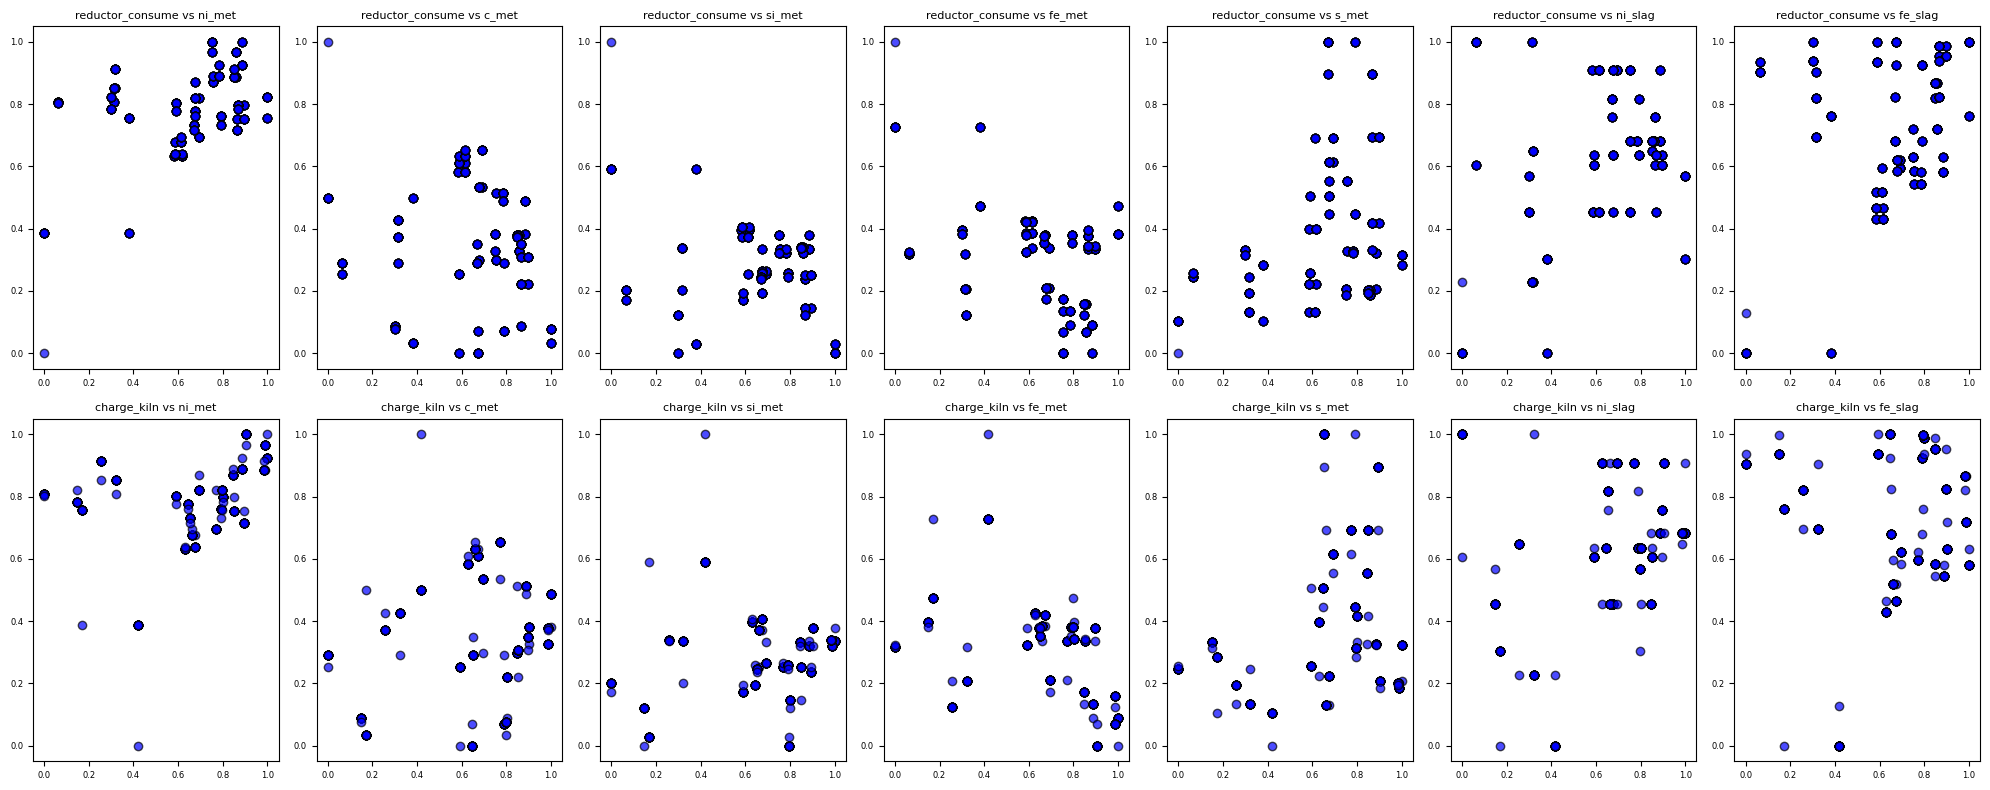

In [48]:
x_columns = normalizeds_df.loc[:, 'reductor_consume':'charge_kiln'].columns
y_columns = normalizeds_df.loc[:, 'ni_met':'fe_slag'].columns

# Setup grid untuk subplots
n_rows = len(x_columns)
n_cols = len(y_columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8), sharex=False, sharey=False)

# Loop untuk membuat scatter plot setiap pasangan kolom
for i, x_col in enumerate(x_columns):
    for j, y_col in enumerate(y_columns):
        ax = axes[i, j]
        ax.scatter(normalizeds_df[x_col], normalizeds_df[y_col], alpha=0.7, color='blue', edgecolors='black')
        ax.set_title(f'{x_col} vs {y_col}', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)

# Menyesuaikan tata letak agar tidak tumpang tindih
plt.tight_layout()
plt.savefig('reductors-compositions_plot_16.png', dpi=300)
plt.show()

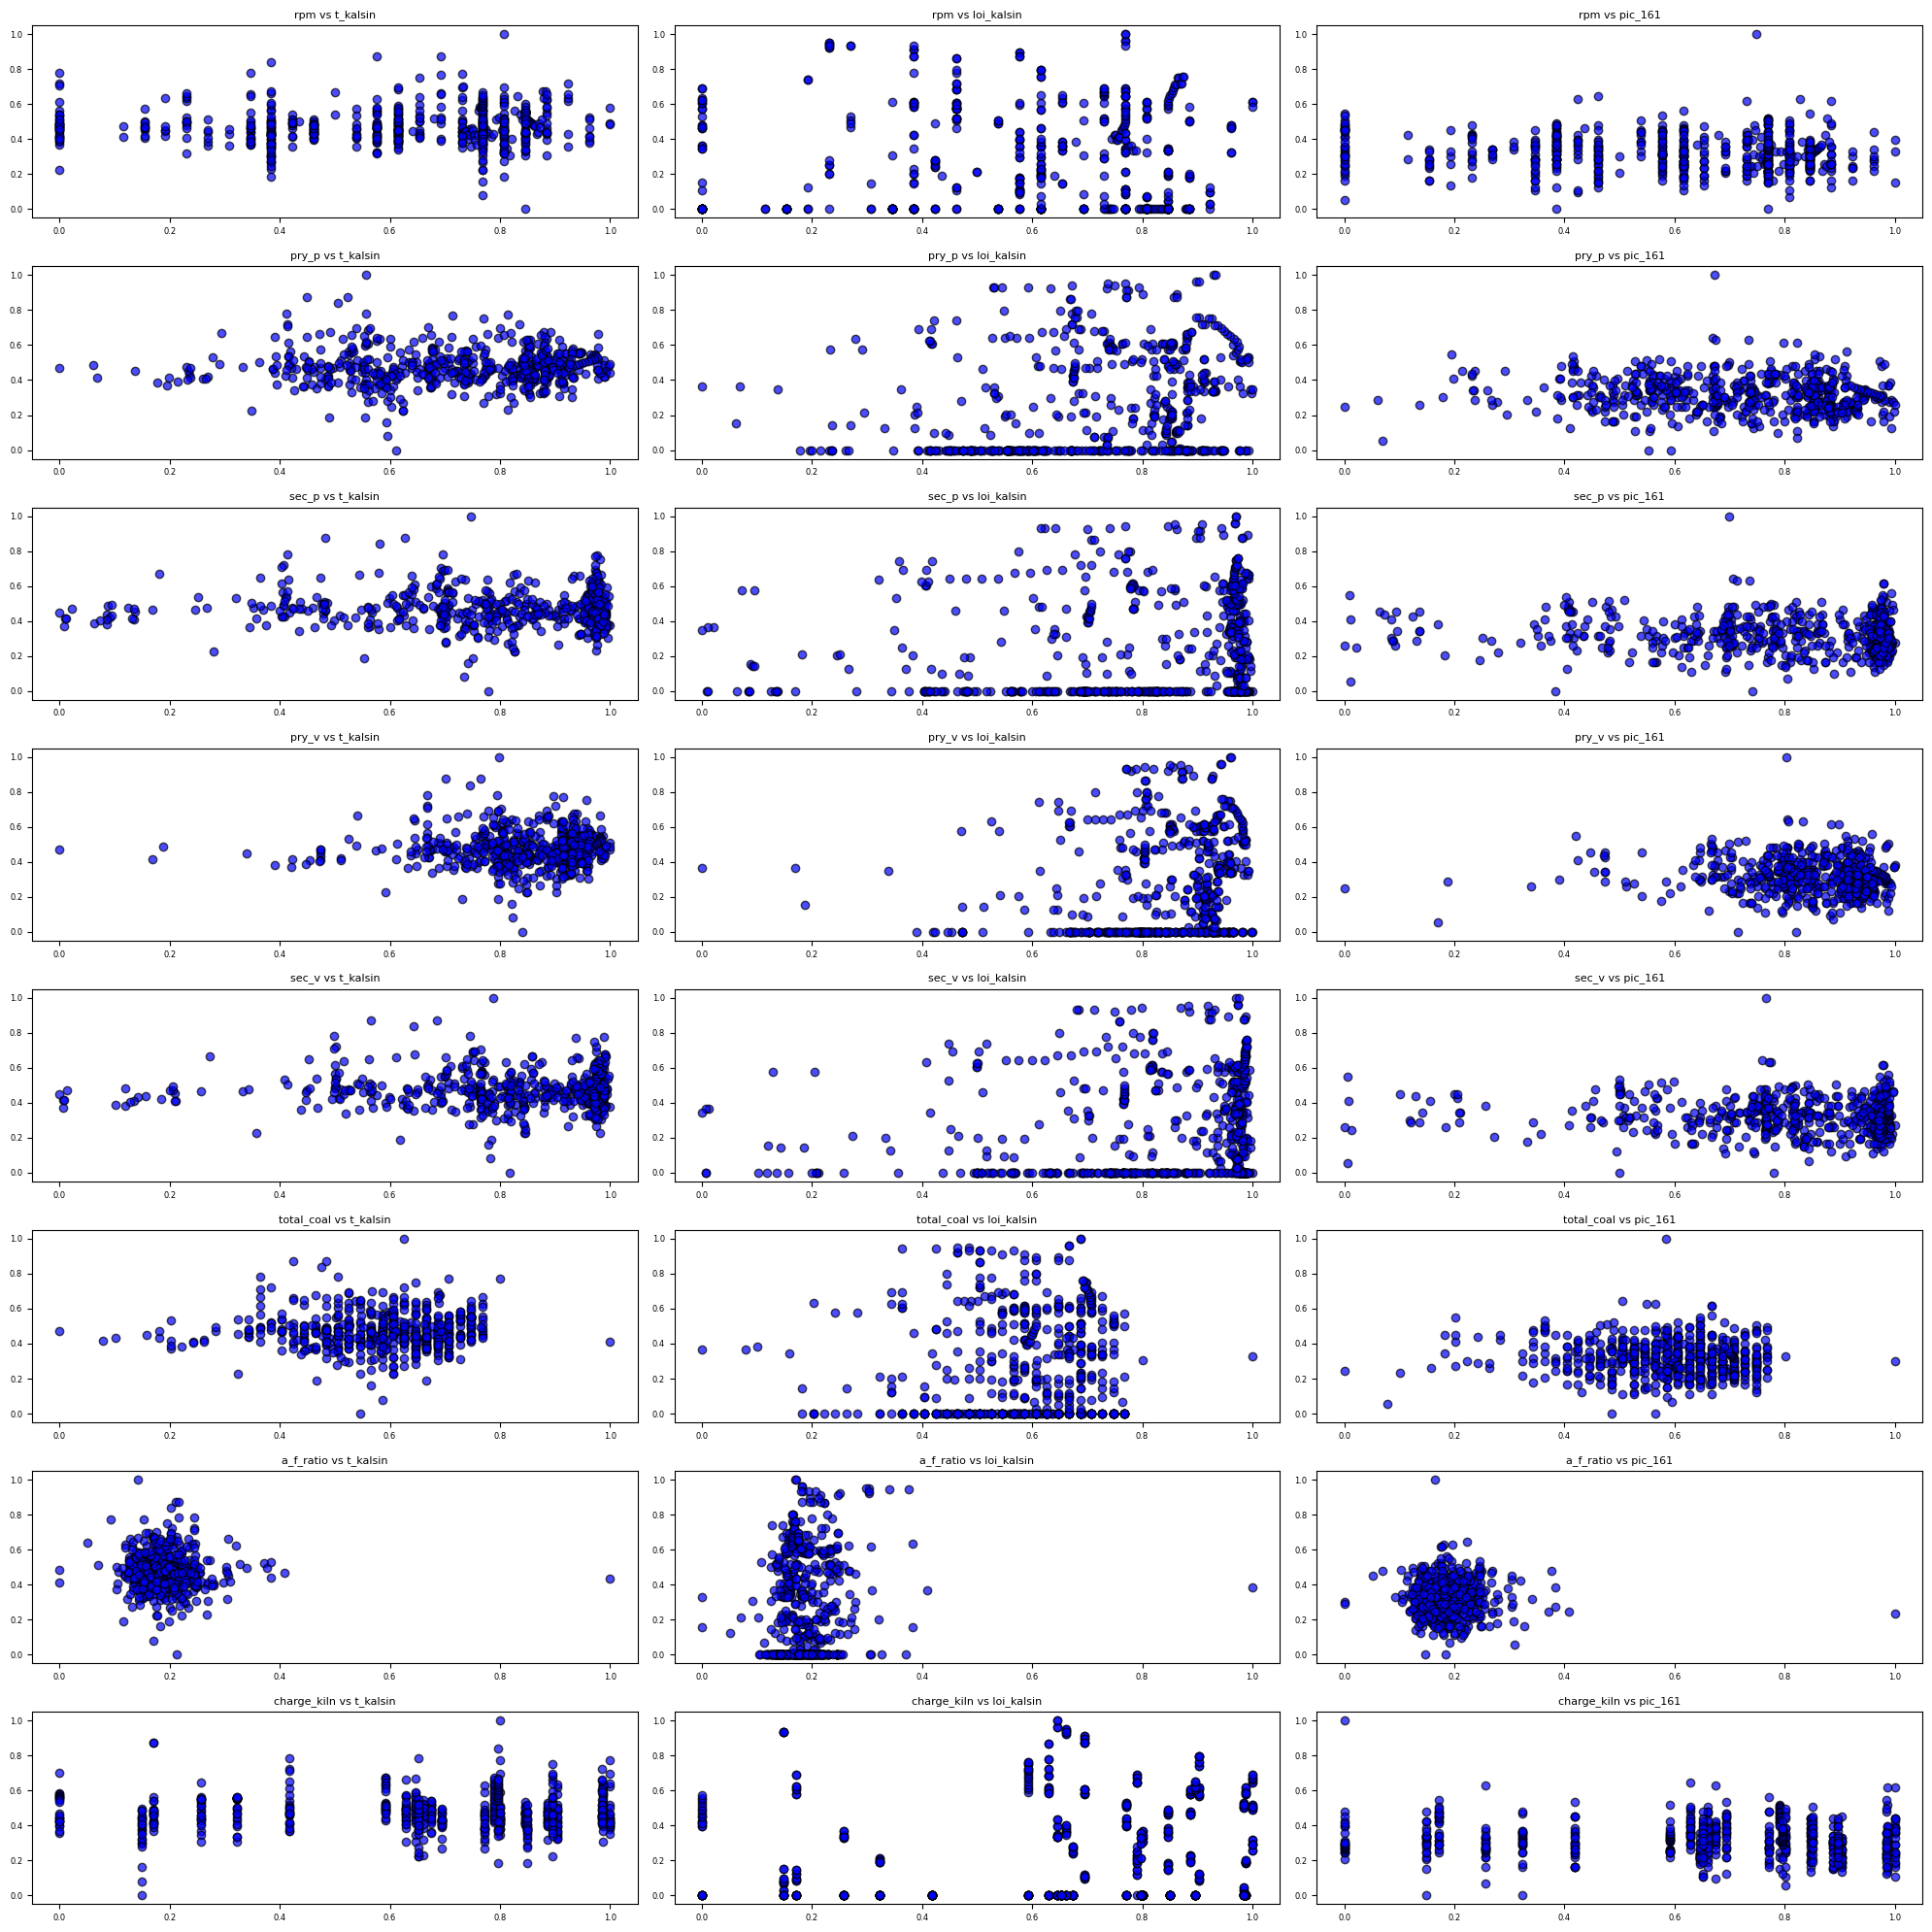

In [49]:
x_columns = ['rpm', 'pry_p', 'sec_p', 'pry_v', 'sec_v', 'total_coal', 'a_f_ratio', 'charge_kiln']
y_columns = ['t_kalsin', 'loi_kalsin', 'pic_161']

# Setup grid untuk subplots
n_rows = len(x_columns)
n_cols = len(y_columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharex=False, sharey=False)

# Loop untuk membuat scatter plot setiap pasangan kolom
for i, x_col in enumerate(x_columns):
    for j, y_col in enumerate(y_columns):
        ax = axes[i, j]
        ax.scatter(normalizeds_df[x_col], normalizeds_df[y_col], alpha=0.7, color='blue', edgecolors='black')
        ax.set_title(f'{x_col} vs {y_col}', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=6)

# Menyesuaikan tata letak agar tidak tumpang tindih
plt.tight_layout()
plt.savefig('params-kalsin_plot_16.png', dpi=300)
plt.show()

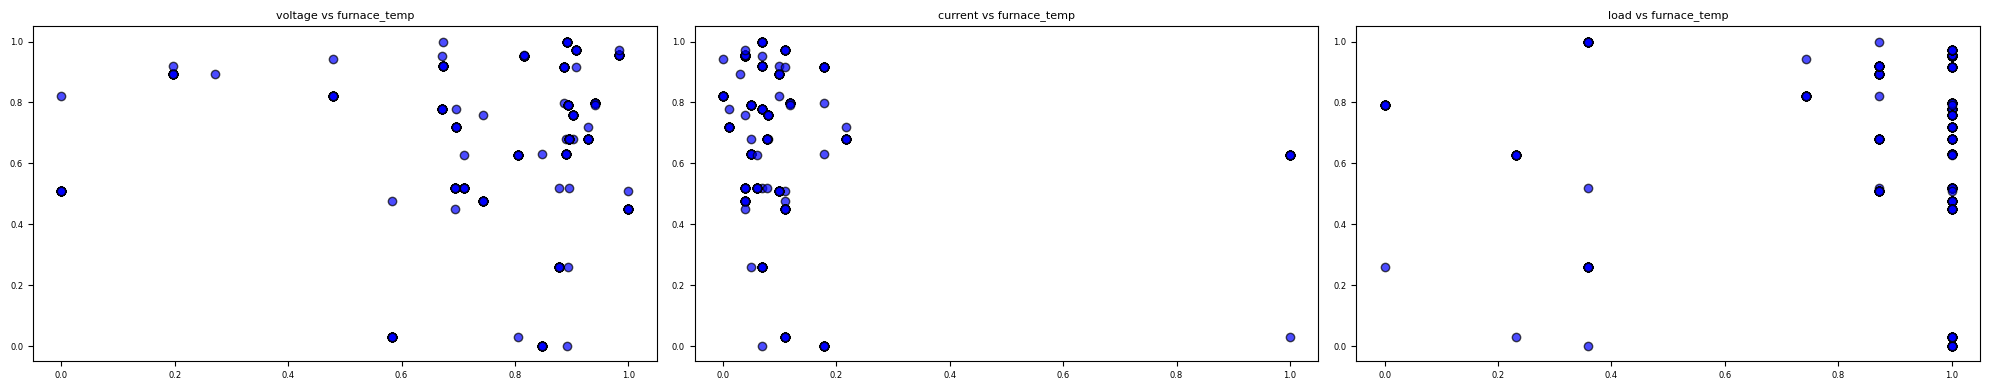

In [50]:
# Define x_columns as a list of columns
x_columns = normalizeds_df.loc[:, 'voltage':'load'].columns  # Select columns from 'voltage' to 'load'
y_column = ['furnace_temp']  # List of columns for y axis

# Setup grid for subplots
n_cols = len(x_columns)

# Create subplots (1 row, multiple columns)
fig, axes = plt.subplots(1, n_cols, figsize=(20, 4), sharex=False, sharey=False)

# Loop to create scatter plot for each pair of columns
for i, x_col in enumerate(x_columns):
    ax = axes[i]  # Corrected indexing
    ax.scatter(normalizeds_df[x_col], normalizeds_df[y_column[0]], alpha=0.7, color='blue', edgecolors='black')
    ax.set_title(f'{x_col} vs {y_column[0]}', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)

# Adjust layout so that plots do not overlap
plt.tight_layout()
plt.savefig('load-furnace_plot_16.png', dpi=300)
plt.show()

## MODELLING

### RK

In [56]:
print(normalizeds_df.columns)


Index(['ni_in', 'fe_in', 'sio2_in', 'cao_in', 'mgo_in', 'al2o3_in', 'fe_ni',
       's_m', 'bc', 'loi_in', 'mc_kilnfeed', 'fc_coal', 'gcv_coal', 'tco',
       'voltage', 'current', 'load', 'rpm', 'pry_p', 'sec_p', 'pry_v', 'sec_v',
       'total_coal', 'a_f_ratio', 'kg_tco', 'reductor_ratio',
       'reductor_consume', 'charge_kiln', 't_tic162', 't_tic163', 't_tic166',
       't_tic172', 'furnace_temp', 'ni_met', 'c_met', 'si_met', 'fe_met',
       's_met', 'ni_slag', 'fe_slag', 't_kalsin', 'pic_161', 'loi_kalsin'],
      dtype='object')


In [57]:
X_rk = normalized_input_rk_df
y_rk = normalized_output_rk_df
X_rk_train, X_rk_test, y_rk_train, y_rk_test = train_test_split(X_rk, y_rk, test_size=0.2, random_state=42)

X_ef = normalized_input_ef_df
y_ef = normalized_output_ef_df
X_ef_train, X_ef_test, y_ef_train, y_ef_test = train_test_split(X_ef, y_ef, test_size=0.2, random_state=42)

In [78]:
y_rk_test.shape

(121, 7)

### Random Forest

In [58]:
rf_rk_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_rk_model.fit(X_rk_train, y_rk_train)
y_pred_rf_rk = rf_rk_model.predict(X_rk_test)
y_pred_rf_rk_df = pd.DataFrame(y_pred_rf_rk, columns=rk_output_cols)

rf_ef_model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
rf_ef_model.fit(X_ef_train, y_ef_train)
y_pred_rf_ef = rf_ef_model.predict(X_ef_test)
y_pred_rf_ef_df = pd.DataFrame(y_pred_rf_ef, columns=ef_output_cols)

### Multi Layer Perceptron

In [59]:
mlp_rk = MLPRegressor(hidden_layer_sizes=(64, 32),  # Example hidden layers
        max_iter=500,
        random_state=42,
        learning_rate_init=0.02,
        verbose=True)

mlp_rk.fit(X_rk_train, y_rk_train)
y_pred_mlp_rk = mlp_rk.predict(X_rk_test)
y_pred_mlp_rk_df = pd.DataFrame(y_pred_mlp_rk, columns=rk_output_cols)

mlp_ef = MLPRegressor(hidden_layer_sizes=(64, 32),  # Example hidden layers
        max_iter=500,
        random_state=42,
        learning_rate_init=0.02,
        verbose=True)

mlp_ef.fit(X_ef_train, y_ef_train)
y_pred_mlp_ef = mlp_ef.predict(X_ef_test)
y_pred_mlp_ef_df = pd.DataFrame(y_pred_mlp_ef, columns=ef_output_cols)

Iteration 1, loss = 0.08930743
Iteration 2, loss = 0.03075882
Iteration 3, loss = 0.01682949
Iteration 4, loss = 0.01841705
Iteration 5, loss = 0.01420199
Iteration 6, loss = 0.01448424
Iteration 7, loss = 0.01326170
Iteration 8, loss = 0.01321717
Iteration 9, loss = 0.01262293
Iteration 10, loss = 0.01248718
Iteration 11, loss = 0.01216645
Iteration 12, loss = 0.01202570
Iteration 13, loss = 0.01202714
Iteration 14, loss = 0.01195812
Iteration 15, loss = 0.01189815
Iteration 16, loss = 0.01175299
Iteration 17, loss = 0.01167528
Iteration 18, loss = 0.01161777
Iteration 19, loss = 0.01153734
Iteration 20, loss = 0.01154959
Iteration 21, loss = 0.01143732
Iteration 22, loss = 0.01143230
Iteration 23, loss = 0.01140432
Iteration 24, loss = 0.01140939
Iteration 25, loss = 0.01132513
Iteration 26, loss = 0.01127090
Iteration 27, loss = 0.01122584
Iteration 28, loss = 0.01113811
Iteration 29, loss = 0.01106761
Iteration 30, loss = 0.01100743
Iteration 31, loss = 0.01096578
Iteration 32, los

### Support Vector Regression

In [60]:
# Initialize SVR
svr_rk = SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='auto')
multi_output_svr_rk = MultiOutputRegressor(svr_rk)
multi_output_svr_rk.fit(X_rk_train, y_rk_train)
y_pred_svr_rk = multi_output_svr_rk.predict(X_rk_test)
y_pred_svr_rk_df = pd.DataFrame(y_pred_svr_rk, columns=rk_output_cols)

svr_ef = SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='auto')
multi_output_svr_ef = MultiOutputRegressor(svr_ef)
multi_output_svr_ef.fit(X_ef_train, y_ef_train)
y_pred_svr_ef = multi_output_svr_ef.predict(X_ef_test)
y_pred_svr_ef_df = pd.DataFrame(y_pred_svr_ef, columns=ef_output_cols)

### Ridge Regression

In [61]:
# Initialize Ridge Regression model
ridge_model_rk = Ridge(alpha=0.1, solver='svd')
ridge_model_rk.fit(X_rk_train, y_rk_train)
y_pred_rr_rk = ridge_model_rk.predict(X_rk_test)
y_pred_rr_rk_df = pd.DataFrame(y_pred_rr_rk, columns=rk_output_cols)

ridge_model_ef = Ridge(alpha=0.1, solver='svd')
ridge_model_ef.fit(X_ef_train, y_ef_train)
y_pred_rr_ef = ridge_model_ef.predict(X_ef_test)
y_pred_rr_ef_df = pd.DataFrame(y_pred_rr_ef, columns=ef_output_cols)

### LASSO

In [62]:
# Define and train the Lasso model for rotary kiln (rk)
lasso_model_rk = Lasso(alpha=0.1, random_state=42)
lasso_model_rk.fit(X_rk_train, y_rk_train)

# Predictions for rotary kiln
y_pred_lasso_rk = lasso_model_rk.predict(X_rk_test)
y_pred_lasso_rk_df = pd.DataFrame(y_pred_lasso_rk, columns=rk_output_cols)


# Define and train the Lasso model for electric furnace (ef)
lasso_model_ef = Lasso(alpha=0.1, random_state=42)
lasso_model_ef.fit(X_ef_train, y_ef_train)

# Predictions for electric furnace
y_pred_lasso_ef = lasso_model_ef.predict(X_ef_test)
y_pred_lasso_ef_df = pd.DataFrame(y_pred_lasso_ef, columns=ef_output_cols)

### KNN

In [63]:
# Define and train the KNN model for rotary kiln (rk)
knn_model_rk = KNeighborsRegressor(n_neighbors=5)  # Adjust n_neighbors as needed
knn_model_rk.fit(X_rk_train, y_rk_train)

# Predictions for rotary kiln
y_pred_knn_rk = knn_model_rk.predict(X_rk_test)
y_pred_knn_rk_df = pd.DataFrame(y_pred_knn_rk, columns=rk_output_cols)

# Define and train the KNN model for electric furnace (ef)
knn_model_ef = KNeighborsRegressor(n_neighbors=5)  # Adjust n_neighbors as needed
knn_model_ef.fit(X_ef_train, y_ef_train)

# Predictions for electric furnace
y_pred_knn_ef = knn_model_ef.predict(X_ef_test)
y_pred_knn_ef_df = pd.DataFrame(y_pred_knn_ef, columns=ef_output_cols)


### GPR

In [64]:
# Define kernel for Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))

In [65]:
# Define and train the GPR model for rotary kiln (rk)
gpr_model_rk = GaussianProcessRegressor(kernel=kernel, random_state=42)
gpr_model_rk.fit(X_rk_train, y_rk_train)

# Predictions for rotary kiln
y_pred_gpr_rk = gpr_model_rk.predict(X_rk_test)
y_pred_gpr_rk_df = pd.DataFrame(y_pred_gpr_rk, columns=rk_output_cols)

# Define and train the GPR model for electric furnace (ef)
gpr_model_ef = GaussianProcessRegressor(kernel=kernel, random_state=42)
gpr_model_ef.fit(X_ef_train, y_ef_train)

# Predictions for electric furnace
y_pred_gpr_ef = gpr_model_ef.predict(X_ef_test)
y_pred_gpr_ef_df = pd.DataFrame(y_pred_gpr_ef, columns=ef_output_cols)


### CNN (Not Compatible on Windows)

### XGBOOST

In [66]:
# XGBoost model for rotary kiln
xgb_model_rk = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model_rk.fit(X_rk_train, y_rk_train)

# XGBoost predictions for rotary kiln
y_pred_xgb_rk = xgb_model_rk.predict(X_rk_test)
y_pred_xgb_rk_df = pd.DataFrame(y_pred_xgb_rk, columns=rk_output_cols)

# XGBoost model for electric furnace
xgb_model_ef = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model_ef.fit(X_ef_train, y_ef_train)

# XGBoost predictions for electric furnace
y_pred_xgb_ef = xgb_model_ef.predict(X_ef_test)
y_pred_xgb_ef_df = pd.DataFrame(y_pred_xgb_ef, columns=ef_output_cols)

### CATBOOST

In [67]:
# Define and train the CatBoost model for rotary kiln (rk) using MultiOutputRegressor
catboost_model_rk = MultiOutputRegressor(CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_state=42))
catboost_model_rk.fit(X_rk_train, y_rk_train)

# Predictions for rotary kiln
y_pred_catboost_rk = catboost_model_rk.predict(X_rk_test)
y_pred_catboost_rk_df = pd.DataFrame(y_pred_catboost_rk, columns=rk_output_cols)

# Define and train the CatBoost model for electric furnace (ef) using MultiOutputRegressor
catboost_model_ef = MultiOutputRegressor(CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_state=42))
catboost_model_ef.fit(X_ef_train, y_ef_train)

# Predictions for electric furnace
y_pred_catboost_ef = catboost_model_ef.predict(X_ef_test)
y_pred_catboost_ef_df = pd.DataFrame(y_pred_catboost_ef, columns=ef_output_cols)

## Performance

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Function to calculate evaluation metrics
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

# Evaluate models for Rotary Kiln
# Random Forest
mse_rf_rk, rmse_rf_rk, mae_rf_rk = evaluate_model(y_rk_test, y_pred_rf_rk_df)
print(f"RF (Rotary Kiln) - MSE: {mse_rf_rk}, RMSE: {rmse_rf_rk}, MAE: {mae_rf_rk}")

# MLP
mse_mlp_rk, rmse_mlp_rk, mae_mlp_rk = evaluate_model(y_rk_test, y_pred_mlp_rk_df)
print(f"MLP (Rotary Kiln) - MSE: {mse_mlp_rk}, RMSE: {rmse_mlp_rk}, MAE: {mae_mlp_rk}")

# SVR
mse_svr_rk, rmse_svr_rk, mae_svr_rk = evaluate_model(y_rk_test, y_pred_svr_rk_df)
print(f"SVR (Rotary Kiln) - MSE: {mse_svr_rk}, RMSE: {rmse_svr_rk}, MAE: {mae_svr_rk}")

# Ridge Regression
mse_rr_rk, rmse_rr_rk, mae_rr_rk = evaluate_model(y_rk_test, y_pred_rr_rk_df)
print(f"Ridge (Rotary Kiln) - MSE: {mse_rr_rk}, RMSE: {rmse_rr_rk}, MAE: {mae_rr_rk}")

# Lasso Regression
mse_lasso_rk, rmse_lasso_rk, mae_lasso_rk = evaluate_model(y_rk_test, y_pred_lasso_rk_df)
print(f"Lasso (Rotary Kiln) - MSE: {mse_lasso_rk}, RMSE: {rmse_lasso_rk}, MAE: {mae_lasso_rk}")

# KNN
mse_knn_rk, rmse_knn_rk, mae_knn_rk = evaluate_model(y_rk_test, y_pred_knn_rk_df)
print(f"KNN (Rotary Kiln) - MSE: {mse_knn_rk}, RMSE: {rmse_knn_rk}, MAE: {mae_knn_rk}")

# GPR
mse_gpr_rk, rmse_gpr_rk, mae_gpr_rk = evaluate_model(y_rk_test, y_pred_gpr_rk_df)
print(f"GPR (Rotary Kiln) - MSE: {mse_gpr_rk}, RMSE: {rmse_gpr_rk}, MAE: {mae_gpr_rk}")

# XGBoost
mse_xgb_rk, rmse_xgb_rk, mae_xgb_rk = evaluate_model(y_rk_test, y_pred_xgb_rk_df)
print(f"XGBoost (Rotary Kiln) - MSE: {mse_xgb_rk}, RMSE: {rmse_xgb_rk}, MAE: {mae_xgb_rk}")

# CatBoost
mse_catboost_rk, rmse_catboost_rk, mae_catboost_rk = evaluate_model(y_rk_test, y_pred_catboost_rk_df)
print(f"CatBoost (Rotary Kiln) - MSE: {mse_catboost_rk}, RMSE: {rmse_catboost_rk}, MAE: {mae_catboost_rk}")

# Evaluate models for Electric Furnace
# Random Forest
mse_rf_ef, rmse_rf_ef, mae_rf_ef = evaluate_model(y_ef_test, y_pred_rf_ef_df)
print(f"RF (Electric Furnace) - MSE: {mse_rf_ef}, RMSE: {rmse_rf_ef}, MAE: {mae_rf_ef}")

# MLP
mse_mlp_ef, rmse_mlp_ef, mae_mlp_ef = evaluate_model(y_ef_test, y_pred_mlp_ef_df)
print(f"MLP (Electric Furnace) - MSE: {mse_mlp_ef}, RMSE: {rmse_mlp_ef}, MAE: {mae_mlp_ef}")

# SVR
mse_svr_ef, rmse_svr_ef, mae_svr_ef = evaluate_model(y_ef_test, y_pred_svr_ef_df)
print(f"SVR (Electric Furnace) - MSE: {mse_svr_ef}, RMSE: {rmse_svr_ef}, MAE: {mae_svr_ef}")

# Ridge Regression
mse_rr_ef, rmse_rr_ef, mae_rr_ef = evaluate_model(y_ef_test, y_pred_rr_ef_df)
print(f"Ridge (Electric Furnace) - MSE: {mse_rr_ef}, RMSE: {rmse_rr_ef}, MAE: {mae_rr_ef}")

# Lasso Regression
mse_lasso_ef, rmse_lasso_ef, mae_lasso_ef = evaluate_model(y_ef_test, y_pred_lasso_ef_df)
print(f"Lasso (Electric Furnace) - MSE: {mse_lasso_ef}, RMSE: {rmse_lasso_ef}, MAE: {mae_lasso_ef}")

# KNN
mse_knn_ef, rmse_knn_ef, mae_knn_ef = evaluate_model(y_ef_test, y_pred_knn_ef_df)
print(f"KNN (Electric Furnace) - MSE: {mse_knn_ef}, RMSE: {rmse_knn_ef}, MAE: {mae_knn_ef}")

# GPR
mse_gpr_ef, rmse_gpr_ef, mae_gpr_ef = evaluate_model(y_ef_test, y_pred_gpr_ef_df)
print(f"GPR (Electric Furnace) - MSE: {mse_gpr_ef}, RMSE: {rmse_gpr_ef}, MAE: {mae_gpr_ef}")

# XGBoost
mse_xgb_ef, rmse_xgb_ef, mae_xgb_ef = evaluate_model(y_ef_test, y_pred_xgb_ef_df)
print(f"XGBoost (Electric Furnace) - MSE: {mse_xgb_ef}, RMSE: {rmse_xgb_ef}, MAE: {mae_xgb_ef}")

# CatBoost
mse_catboost_ef, rmse_catboost_ef, mae_catboost_ef = evaluate_model(y_ef_test, y_pred_catboost_ef_df)
print(f"CatBoost (Electric Furnace) - MSE: {mse_catboost_ef}, RMSE: {rmse_catboost_ef}, MAE: {mae_catboost_ef}")


RF (Rotary Kiln) - MSE: 0.007686057736386704, RMSE: 0.08767016445967639, MAE: 0.05460246121202102
MLP (Rotary Kiln) - MSE: 0.02281197224774807, RMSE: 0.15103632757634194, MAE: 0.1077238246689723
SVR (Rotary Kiln) - MSE: 0.01635157968490483, RMSE: 0.12787329543303727, MAE: 0.08849990739968418
Ridge (Rotary Kiln) - MSE: 0.01805077221751399, RMSE: 0.13435316229071048, MAE: 0.09446525529527881
Lasso (Rotary Kiln) - MSE: 0.02534093874574137, RMSE: 0.15918837503329622, MAE: 0.11511928460807118
KNN (Rotary Kiln) - MSE: 0.008617237791356272, RMSE: 0.09282907837179184, MAE: 0.05971907441730736
GPR (Rotary Kiln) - MSE: 0.23379576297269392, RMSE: 0.48352431476885827, MAE: 0.41188326434997485
XGBoost (Rotary Kiln) - MSE: 0.008069534573130146, RMSE: 0.08983058818203377, MAE: 0.05517365600231735
CatBoost (Rotary Kiln) - MSE: 0.007415670960770762, RMSE: 0.08611429010780244, MAE: 0.05351139255160203
RF (Electric Furnace) - MSE: 0.005089889187062575, RMSE: 0.07134345931522086, MAE: 0.02792964799575205


In [83]:
# Function to calculate RMSE, MSE, and MAE for each output feature
def evaluate_model(y_true, y_pred, output_cols):
    metrics = {}
    for i, col in enumerate(output_cols):
        mse = mean_squared_error(y_true.iloc[:, i], y_pred.iloc[:, i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true.iloc[:, i], y_pred.iloc[:, i])
        metrics[col] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}
    return metrics

# Evaluate RandomForest for Rotary Kiln
rf_rk_metrics = evaluate_model(y_rk_test, y_pred_rf_rk_df, rk_output_cols)
print("RandomForest RK Metrics:")
print(rf_rk_metrics)

# Evaluate RandomForest for Electric Furnace
rf_ef_metrics = evaluate_model(y_ef_test, y_pred_rf_ef_df, ef_output_cols)
print("RandomForest EF Metrics:")
print(rf_ef_metrics)

# Evaluate MLP for Rotary Kiln
mlp_rk_metrics = evaluate_model(y_rk_test, y_pred_mlp_rk_df, rk_output_cols)
print("MLP RK Metrics:")
print(mlp_rk_metrics)

# Evaluate MLP for Electric Furnace
mlp_ef_metrics = evaluate_model(y_ef_test, y_pred_mlp_ef_df, ef_output_cols)
print("MLP EF Metrics:")
print(mlp_ef_metrics)

# Evaluate SVR for Rotary Kiln
svr_rk_metrics = evaluate_model(y_rk_test, y_pred_svr_rk_df, rk_output_cols)
print("SVR RK Metrics:")
print(svr_rk_metrics)

# Evaluate SVR for Electric Furnace
svr_ef_metrics = evaluate_model(y_ef_test, y_pred_svr_ef_df, ef_output_cols)
print("SVR EF Metrics:")
print(svr_ef_metrics)

# Evaluate Ridge Regression for Rotary Kiln
ridge_rk_metrics = evaluate_model(y_rk_test, y_pred_rr_rk_df, rk_output_cols)
print("Ridge Regression RK Metrics:")
print(ridge_rk_metrics)

# Evaluate Ridge Regression for Electric Furnace
ridge_ef_metrics = evaluate_model(y_ef_test, y_pred_rr_ef_df, ef_output_cols)
print("Ridge Regression EF Metrics:")
print(ridge_ef_metrics)

# Evaluate Lasso for Rotary Kiln
lasso_rk_metrics = evaluate_model(y_rk_test, y_pred_lasso_rk_df, rk_output_cols)
print("Lasso RK Metrics:")
print(lasso_rk_metrics)

# Evaluate Lasso for Electric Furnace
lasso_ef_metrics = evaluate_model(y_ef_test, y_pred_lasso_ef_df, ef_output_cols)
print("Lasso EF Metrics:")
print(lasso_ef_metrics)

# Evaluate KNN for Rotary Kiln
knn_rk_metrics = evaluate_model(y_rk_test, y_pred_knn_rk_df, rk_output_cols)
print("KNN RK Metrics:")
print(knn_rk_metrics)

# Evaluate KNN for Electric Furnace
knn_ef_metrics = evaluate_model(y_ef_test, y_pred_knn_ef_df, ef_output_cols)
print("KNN EF Metrics:")
print(knn_ef_metrics)

# Evaluate GPR for Rotary Kiln
gpr_rk_metrics = evaluate_model(y_rk_test, y_pred_gpr_rk_df, rk_output_cols)
print("GPR RK Metrics:")
print(gpr_rk_metrics)

# Evaluate GPR for Electric Furnace
gpr_ef_metrics = evaluate_model(y_ef_test, y_pred_gpr_ef_df, ef_output_cols)
print("GPR EF Metrics:")
print(gpr_ef_metrics)

# Evaluate XGBoost for Rotary Kiln
xgb_rk_metrics = evaluate_model(y_rk_test, y_pred_xgb_rk_df, rk_output_cols)
print("XGBoost RK Metrics:")
print(xgb_rk_metrics)

# Evaluate XGBoost for Electric Furnace
xgb_ef_metrics = evaluate_model(y_ef_test, y_pred_xgb_ef_df, ef_output_cols)
print("XGBoost EF Metrics:")
print(xgb_ef_metrics)

# Evaluate CatBoost for Rotary Kiln
catboost_rk_metrics = evaluate_model(y_rk_test, y_pred_catboost_rk_df, rk_output_cols)
print("CatBoost RK Metrics:")
print(catboost_rk_metrics)

# Evaluate CatBoost for Electric Furnace
catboost_ef_metrics = evaluate_model(y_ef_test, y_pred_catboost_ef_df, ef_output_cols)
print("CatBoost EF Metrics:")
print(catboost_ef_metrics)

RandomForest RK Metrics:
{'t_tic162': {'MSE': 0.0067837553516382565, 'RMSE': 0.0823635559676624, 'MAE': 0.031220158921063616}, 't_tic163': {'MSE': 0.0035313306506573575, 'RMSE': 0.05942500021588017, 'MAE': 0.04340867233916261}, 't_tic166': {'MSE': 0.004287860926048343, 'RMSE': 0.06548176025465674, 'MAE': 0.050918986552797904}, 't_tic172': {'MSE': 0.010002629641195545, 'RMSE': 0.10001314734171475, 'MAE': 0.07078344221989334}, 't_kalsin': {'MSE': 0.00825611138306752, 'RMSE': 0.09086314645150431, 'MAE': 0.0641695685388932}, 'pic_161': {'MSE': 0.008052674134916464, 'RMSE': 0.08973669335849446, 'MAE': 0.06792185221404547}, 'loi_kalsin': {'MSE': 0.012888042067183424, 'RMSE': 0.11352551284703992, 'MAE': 0.05379454769829098}}
RandomForest EF Metrics:
{'t_tic162': {'MSE': 0.005071753367355523, 'RMSE': 0.07121624370433702, 'MAE': 0.03293866584518672}, 't_tic163': {'MSE': 0.004476608087236954, 'RMSE': 0.06690745913003239, 'MAE': 0.0488418924533739}, 't_tic166': {'MSE': 0.0036361024392067296, 'RMS